In [35]:
import pandas as pd
import xarray as xr
import numpy as np
import scipy.stats as stats
import requests
import rasterio
from rasterio.plot import show
import richdem as rd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.stats import poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import math

In [2]:
dem = rd.LoadGDAL('dem2.tif')
dem

rdarray([[2694, 2698, 2703, ..., 1147, 1145, 1144],
         [2691, 2696, 2700, ..., 1148, 1146, 1144],
         [2689, 2694, 2698, ..., 1148, 1147, 1146],
         ...,
         [1938, 1937, 1936, ..., 1248, 1245, 1243],
         [1938, 1936, 1937, ..., 1246, 1245, 1243],
         [1938, 1939, 1941, ..., 1245, 1244, 1244]],
        shape=(18000, 32400), dtype=int16)

In [3]:
elev_data = []
row_arr = np.array_split(dem, 20)
#print(row_arr)
for arr in row_arr:
    col_arr = np.array_split(arr, 36, axis = 1)
    row_means = []
    for arr in col_arr:
        row_means.append(float(np.mean(arr)))
    row_means.reverse()
    elev_data.append(row_means)
    

elev_data

[[1164.745275308642,
  1259.4174086419753,
  1328.0675950617283,
  1392.8115925925927,
  1468.6310395061728,
  1547.4061913580247,
  1615.2626839506172,
  1683.9939679012346,
  1772.0719530864199,
  1903.2392802469135,
  2071.7216913580246,
  2398.0813592592594,
  2208.089612345679,
  2231.544825925926,
  2705.7709567901234,
  2978.505422222222,
  2356.085997530864,
  2209.4128814814817,
  2418.0644814814814,
  2332.1442469135804,
  2114.0441074074074,
  2042.5506382716048,
  2089.957451851852,
  2144.225335802469,
  2238.237797530864,
  2137.325750617284,
  2225.3240567901234,
  2044.6558851851853,
  1931.4317592592593,
  1978.1712691358025,
  2045.7489098765432,
  2051.013113580247,
  2131.9722,
  2218.269274074074,
  2023.609561728395,
  2349.166951851852],
 [1206.2687493827161,
  1270.677537037037,
  1328.4624185185185,
  1403.1874703703704,
  1481.8800703703703,
  1551.673013580247,
  1592.1038098765432,
  1672.4193827160493,
  1797.2968839506173,
  1913.35477654321,
  2130.261380

In [4]:
lon_edges = np.arange(-100.5, -111.5 - 0.25, -0.25)
lat_edges = np.arange(35.5, 42.5 + 0.25, 0.25)

len(lon_edges)
len(lat_edges)

29

In [5]:
aval_2025 = pd.read_csv('../Data/every_reported_colorado_avalanche_2025.csv')
aval_2025['Date'] = aval_2025['Date'].str.split(' GMT').str[0]
aval_2025['Date'] = pd.to_datetime(aval_2025['Date'])
aval_2025['Date'] = aval_2025['Date'].dt.strftime('%b %d')
aval_2025 = aval_2025.loc[:, ["Date", "Longitude", "latitude", "Type"]]
aval_2025
avalanche_date = aval_2025[aval_2025['Date'] == 'Feb 25']
for i in range(len(aval_2025)):
    if (aval_2025['Longitude'][i] == ' -'):
        aval_2025 = aval_2025.drop(i)
    elif ((float(aval_2025['Longitude'][i]) < -111.5 or float(aval_2025['Longitude'][i]) > -100.5) or (float(aval_2025['latitude'][i]) < 35.5 or float(aval_2025['latitude'][i]) > 42.5)):
        aval_2025 = aval_2025.drop(i)
aval_2025

,Date,Longitude,latitude,Type
0,Mar 30,-105.8925128,40.5208158,SS
1,Mar 30,-105.7898892,39.8041827,SS
2,Mar 30,-105.8211728,39.6442214,SS
3,Mar 30,-105.8925128,40.5208158,SS
4,Mar 30,-105.8925128,40.5208158,WL
...,...,...,...,...
2793,Nov 06,-107.6064493,37.7908305,SS
2794,Nov 05,-107.0376817,39.00537,SS
2795,Nov 05,-107.0376817,39.00537,L
2796,Nov 05,-107.1211267,38.9072657,SS


In [87]:
aval_2025['Date'] = pd.to_datetime(aval_2025['Date'], format='%b %d')

current_year = pd.Timestamp('now').year
def assign_year(dt):
    if dt.month >= 11 and dt.day:
        return dt.replace(year=2024)
    else:
        return dt.replace(year=2025)

aval_2025['Date'] = aval_2025['Date'].apply(assign_year)

# Group the DataFrame by week
weekly_groups = aval_2025.groupby(pd.Grouper(key='Date', freq='W'))

# Iterate through the weekly groups
for week, group in weekly_groups:
    print(f"--- Week of {week.strftime('%Y-%m-%d')} ---")
    print(group["Type"])
    # You can now perform operations on the 'group' DataFrame for each week

--- Week of 2024-11-10 ---
2794     SS
2795      L
2796     SS
2797     SS
2792      L
2793     SS
2788     WL
2789     SS
2790     HS
2791      L
2787     SS
2778     SS
2779     SS
2780      U
2781     SS
2782      L
2783     HS
2784     SS
2785     SS
2786     SS
2772      L
2773     WL
2774     WL
2775     SS
2776     HS
2777      -
Name: Type, dtype: object
--- Week of 2024-11-17 ---
2767     SS
2768     SS
2769     SS
2770     SS
2771     SS
2764      L
2765     SS
2766     SS
2758     SS
2759     SS
2760     HS
2761     SS
2762     HS
2763      -
2742     HS
2743     HS
2744     SS
2745     SS
2746     SS
2747     HS
2748     SS
2749     HS
2750     SS
2751      -
2752      -
2753      -
2754     SS
2755      -
2756     SS
2757     SS
2741     HS
2739     SS
2740     SS
Name: Type, dtype: object
--- Week of 2024-11-24 ---
2726     SS
2727     HS
2728     SS
2729     SS
2730     SS
2731     SS
2732      -
2733     SS
2734     SS
2735     SS
2736     SS
2737     SS
2738     SS
272

In [8]:
aval_2025

,Date,Longitude,latitude,Type
0,2025-03-30,-105.8925128,40.5208158,SS
1,2025-03-30,-105.7898892,39.8041827,SS
2,2025-03-30,-105.8211728,39.6442214,SS
3,2025-03-30,-105.8925128,40.5208158,SS
4,2025-03-30,-105.8925128,40.5208158,WL
...,...,...,...,...
2793,2024-11-06,-107.6064493,37.7908305,SS
2794,2024-11-05,-107.0376817,39.00537,SS
2795,2024-11-05,-107.0376817,39.00537,L
2796,2024-11-05,-107.1211267,38.9072657,SS


In [ ]:
aval_prop = []
#week_ints = []
for aval_type in [' SS', ' WL', ' U', ' WS', ' L', ' HS', ' G', ' C']:
    weekly_prop = []
    week_ints = []
    for week, group in weekly_groups:
        week_ints.append(week)
        weekly_prop.append((group["Type"] == aval_type).sum() / len(group))
    aval_prop.append(weekly_prop)

In [10]:
aval_prop

[[np.float64(0.5),
  np.float64(0.6060606060606061),
  np.float64(0.5),
  np.float64(0.875751503006012),
  np.float64(0.35714285714285715),
  np.float64(0.6333333333333333),
  np.float64(0.23684210526315788),
  np.float64(0.7931034482758621),
  np.float64(0.6536585365853659),
  np.float64(0.5093167701863354),
  np.float64(0.3333333333333333),
  np.float64(0.4067796610169492),
  np.float64(0.3673469387755102),
  np.float64(0.16326530612244897),
  np.float64(0.8181818181818182),
  np.float64(0.5265151515151515),
  np.float64(0.17777777777777778),
  np.float64(0.75),
  np.float64(0.7045454545454546),
  np.float64(0.6180555555555556),
  np.float64(0.16939890710382513)],
 [np.float64(0.11538461538461539),
  np.float64(0.0),
  np.float64(0.0),
  np.float64(0.004008016032064128),
  np.float64(0.0),
  np.float64(0.0),
  np.float64(0.0),
  np.float64(0.0),
  np.float64(0.0),
  np.float64(0.0),
  np.float64(0.15151515151515152),
  np.float64(0.0),
  np.float64(0.24489795918367346),
  np.float64(

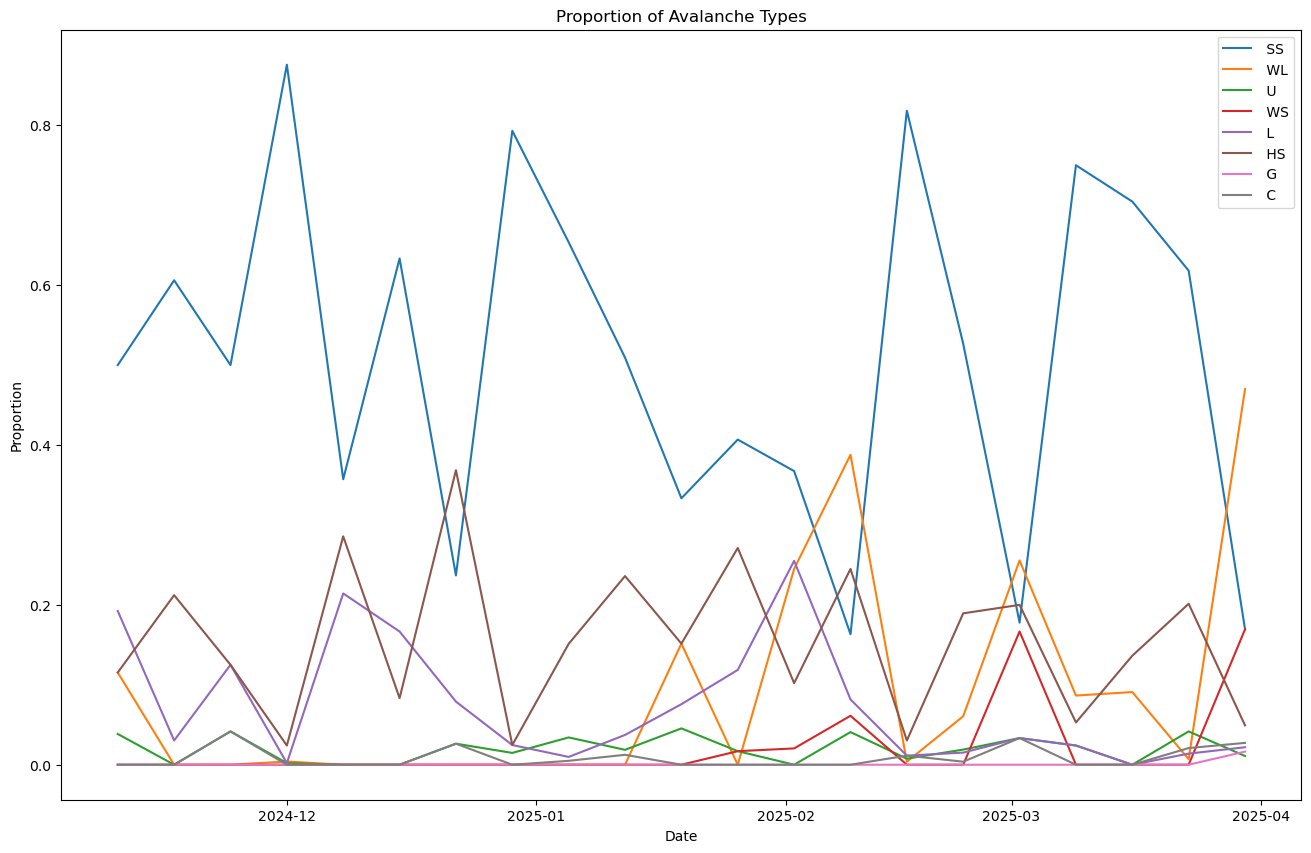

In [240]:
#x_values = range(len(aval_prop[0]))
plt.figure(figsize=(16, 10))

for aval_type in aval_prop:
    plt.plot(week_ints, aval_type)

plt.xlabel("Date")
plt.ylabel("Proportion")
plt.title("Proportion of Avalanche Types")
plt.legend([' SS', ' WL', ' U', ' WS', ' L', ' HS', ' G', ' C'])
plt.show()

In [62]:
def find_surrounding_cells(i, j, max_i, max_j):
    surrounding = []
    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:
            ni, nj = i + di, j + dj
            if 0 <= ni < max_i and 0 <= nj < max_j:
                surrounding.append((int(ni), int(nj)))
    return surrounding

find_surrounding_cells(42, 20, 45, 29)

[(41, 19),
 (41, 20),
 (41, 21),
 (42, 19),
 (42, 20),
 (42, 21),
 (43, 19),
 (43, 20),
 (43, 21)]

In [63]:
avalanche_cells = set()
for lon, lat in zip(aval_2025['Longitude'], aval_2025['latitude']):
    lon_index = np.where((float(lon) <= lon_edges[:-1]) & (float(lon) > lon_edges[1:]))[0]
    lat_index = np.where((float(lat) >= lat_edges[:-1]) & (float(lat) < lat_edges[1:]))[0]
    cells = find_surrounding_cells(int(lon_index[0]), int(lat_index[0]), 45, 29)
    for cell in cells:
        avalanche_cells.add(cell)

In [64]:
avalanche_cells = list(avalanche_cells)
avalanche_cells = sorted(avalanche_cells, key=lambda x: x[1])
avalanche_cells = sorted(avalanche_cells, key=lambda x: x[0])
avalanche_cells

[(16, 12),
 (16, 13),
 (16, 14),
 (17, 6),
 (17, 7),
 (17, 8),
 (17, 12),
 (17, 13),
 (17, 14),
 (18, 6),
 (18, 7),
 (18, 8),
 (18, 12),
 (18, 13),
 (18, 14),
 (19, 6),
 (19, 7),
 (19, 8),
 (19, 9),
 (19, 10),
 (19, 12),
 (19, 13),
 (19, 14),
 (19, 15),
 (19, 16),
 (19, 17),
 (19, 18),
 (19, 19),
 (19, 20),
 (20, 8),
 (20, 9),
 (20, 10),
 (20, 14),
 (20, 15),
 (20, 16),
 (20, 17),
 (20, 18),
 (20, 19),
 (20, 20),
 (20, 21),
 (21, 8),
 (21, 9),
 (21, 10),
 (21, 13),
 (21, 14),
 (21, 15),
 (21, 16),
 (21, 17),
 (21, 18),
 (21, 19),
 (21, 20),
 (21, 21),
 (22, 5),
 (22, 6),
 (22, 7),
 (22, 10),
 (22, 11),
 (22, 12),
 (22, 13),
 (22, 14),
 (22, 15),
 (22, 16),
 (22, 17),
 (22, 18),
 (22, 19),
 (22, 20),
 (22, 21),
 (23, 5),
 (23, 6),
 (23, 7),
 (23, 8),
 (23, 9),
 (23, 10),
 (23, 11),
 (23, 12),
 (23, 13),
 (23, 14),
 (23, 15),
 (23, 16),
 (23, 17),
 (23, 18),
 (23, 19),
 (23, 20),
 (23, 21),
 (23, 22),
 (24, 5),
 (24, 6),
 (24, 7),
 (24, 8),
 (24, 9),
 (24, 10),
 (24, 11),
 (24, 12),
 (24

In [16]:
precip_data_24 = xr.open_dataset("../Data/2024_accum.nc")
inst_data_24 = xr.open_dataset("../Data/2024_instant.nc")
precip_data_25 = xr.open_dataset("../Data/2025_accum.nc")
inst_data_25 = xr.open_dataset("../Data/2025_instant.nc")

precip_data_24

<xarray.Dataset> Size: 15MB
Dimensions:     (valid_time: 1464, latitude: 29, longitude: 45)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 12kB 2024-11-01 ... 2024-12-31T23...
  * latitude    (latitude) float64 232B 42.5 42.25 42.0 ... 36.0 35.75 35.5
  * longitude   (longitude) float64 360B -111.5 -111.2 -111.0 ... -100.8 -100.5
    expver      (valid_time) <U4 23kB ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 8MB ...
    ssrd        (valid_time, latitude, longitude) float32 8MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-02T22:44 GRIB to CDM+CF via cfgrib-0.9.1...

In [17]:
ds_merged = xr.concat([precip_data_24, precip_data_25], dim = "valid_time") # Assuming 'time' is the dimension to concatenate
ds_merged.to_netcdf('24_25_accum.nc')
ds_merged = xr.concat([inst_data_24, inst_data_25], dim = "valid_time") # Assuming 'time' is the dimension to concatenate
ds_merged.to_netcdf('24_25_intstant.nc')

In [20]:
for week, group in weekly_groups:
    print(week)

2024-11-10 00:00:00
2024-11-17 00:00:00
2024-11-24 00:00:00
2024-12-01 00:00:00
2024-12-08 00:00:00
2024-12-15 00:00:00
2024-12-22 00:00:00
2024-12-29 00:00:00
2025-01-05 00:00:00
2025-01-12 00:00:00
2025-01-19 00:00:00
2025-01-26 00:00:00
2025-02-02 00:00:00
2025-02-09 00:00:00
2025-02-16 00:00:00
2025-02-23 00:00:00
2025-03-02 00:00:00
2025-03-09 00:00:00
2025-03-16 00:00:00
2025-03-23 00:00:00
2025-03-30 00:00:00


In [34]:
accum_data = xr.open_dataset("../Data/24_25_accum.nc")
inst_data = xr.open_dataset("../Data/24_25_instant.nc")

accum_data
inst_data

<xarray.Dataset> Size: 57MB
Dimensions:     (valid_time: 3624, latitude: 29, longitude: 45)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 29kB 2024-11-01 ... 2025-03-31T23...
  * latitude    (latitude) float64 232B 42.5 42.25 42.0 ... 36.0 35.75 35.5
  * longitude   (longitude) float64 360B -111.5 -111.2 -111.0 ... -100.8 -100.5
    expver      (valid_time) <U4 58kB ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 19MB ...
    v10         (valid_time, latitude, longitude) float32 19MB ...
    t2m         (valid_time, latitude, longitude) float32 19MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-02T22:44 GRIB to CDM+CF via cfgrib-0.9.1...

In [50]:
aval_count = []
for week, group in weekly_groups:
    aval_count.append(len(group))

len(aval_count)

21

In [52]:

weekly_tp = accum_data['tp'].resample(valid_time='W').sum().mean(dim=['latitude', 'longitude'])[1:-1]
weekly_ssrd = accum_data['ssrd'].resample(valid_time='W').mean().mean(dim=['latitude', 'longitude'])[1:-1]
#weekly_max_windspeed = math.sqrt((inst_data['u10'].resample(valid_time='W').max().mean(dim=['latitude', 'longitude']))^2 + (inst_data['v10'].resample(valid_time='W').max().mean(dim=['latitude', 'longitude']))^2)
weekly_u10 = inst_data['u10'].resample(valid_time='W').max().mean(dim=['latitude', 'longitude'])[1:-1]
weekly_v10 = inst_data['v10'].resample(valid_time='W').max().mean(dim=['latitude', 'longitude'])[1:-1]
weekly_temp = inst_data['v10'].resample(valid_time='W').mean().mean(dim=['latitude', 'longitude'])[1:-1]
weekly_tp

<xarray.DataArray 'tp' (valid_time: 21)> Size: 84B
array([3.3321489e-02, 2.1828371e-03, 5.7061692e-03, 7.9059955e-03,
       1.4697181e-05, 2.0094342e-03, 7.7015231e-04, 5.5591371e-03,
       5.4589175e-03, 5.1469351e-03, 2.3933067e-03, 2.3257362e-03,
       3.4157853e-03, 2.5006726e-03, 1.1382480e-02, 5.2404739e-03,
       6.9041492e-04, 1.3575122e-02, 5.5721565e-03, 6.2722210e-03,
       6.0812095e-03], dtype=float32)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 168B 2024-11-10 ... 2025-03-30

In [45]:
weekly_temp

<xarray.DataArray 'v10' (valid_time: 22)> Size: 88B
array([-1.4278241 ,  1.037689  ,  0.3467522 ,  0.07038257,  0.24034822,
        0.20204817,  0.3703001 ,  0.7096585 , -0.10279764, -1.2912598 ,
       -0.559348  , -0.7053906 ,  0.3684322 ,  1.3753804 ,  0.361053  ,
        0.36423734, -0.09074322, -0.29303554,  0.6911915 ,  0.05576248,
        0.47767693,  1.8179014 ], dtype=float32)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 176B 2024-11-10 ... 2025-04-06

In [ ]:
df = pd.DataFrame({'avalanche_count': aval_count, 'precip': weekly_tp, 'rad': weekly_ssrd, 'temp': weekly_tp, 'u10': weekly_u10, 'v10': weekly_v10, 'elev': elev_by_cell})

In [61]:
weekly_tp = accum_data.tp.resample(valid_time="W").sum()[1:-1]
weekly_ssrd = accum_data.ssrd.resample(valid_time="W").mean()[1:-1]
weekly_u10 = inst_data.u10.resample(valid_time="W").max()[1:-1]
weekly_v10 = inst_data.v10.resample(valid_time="W").max()[1:-1]
weekly_temp = inst_data.t2m.resample(valid_time="W").mean()[1:-1]

weekly_tp

<xarray.DataArray 'tp' (valid_time: 21, latitude: 29, longitude: 45)> Size: 110kB
array([[[6.48212433e-03, 6.42299652e-03, 6.24608994e-03, ...,
         1.63903236e-02, 1.61228180e-02, 1.67646408e-02],
        [5.35011292e-03, 6.34860992e-03, 5.69963455e-03, ...,
         2.04024315e-02, 1.81007385e-02, 1.87869072e-02],
        [5.66864014e-03, 5.52511215e-03, 3.17239761e-03, ...,
         2.52075195e-02, 2.47974396e-02, 2.42242813e-02],
        ...,
        [2.76708603e-03, 1.18446350e-03, 1.75905228e-03, ...,
         6.41260147e-02, 6.76021576e-02, 7.34639168e-02],
        [3.89814377e-03, 2.06470490e-03, 1.89352036e-03, ...,
         6.65802956e-02, 6.40516281e-02, 6.96768761e-02],
        [4.34017181e-03, 3.35168839e-03, 2.53152847e-03, ...,
         6.14261627e-02, 5.64632416e-02, 6.33525848e-02]],

       [[1.07655525e-02, 8.79240036e-03, 7.79199600e-03, ...,
         2.24590302e-03, 4.64010239e-03, 6.50739670e-03],
        [1.15489960e-02, 7.27796555e-03, 4.25195694e-03, ...,
         3.15427780e-03, 7.37380981e-03, 7.58981705e-03],
        [8.88490677e-03, 6.71052933e-03, 4.37021255e-03, ...,
         5.30767441e-03, 8.05521011e-03, 7.48586655e-03],
...
         1.03473663e-03, 8.14914703e-04, 6.96182251e-04],
        [3.25679779e-04, 1.01089478e-04, 7.39097595e-05, ...,
         4.62055206e-04, 3.83377075e-04, 2.81333923e-04],
        [6.19411469e-04, 1.64985657e-04, 1.07765198e-04, ...,
         1.51634216e-04, 1.16348267e-04, 9.05990601e-05]],

       [[5.09691238e-03, 4.37545776e-03, 4.64677811e-03, ...,
         2.63638496e-02, 2.30140686e-02, 2.21991539e-02],
        [5.12313843e-03, 3.55958939e-03, 2.78425217e-03, ...,
         2.18772888e-02, 1.95178986e-02, 1.98297501e-02],
        [7.44199753e-03, 4.57239151e-03, 2.68030167e-03, ...,
         1.82089806e-02, 1.77307129e-02, 1.84702873e-02],
        ...,
        [1.83105469e-04, 3.07083130e-04, 9.67979431e-04, ...,
         4.19139862e-04, 5.45978546e-04, 8.76426697e-04],
        [1.72615051e-04, 2.85625458e-04, 9.65595245e-04, ...,
         4.20570374e-04, 7.08580017e-04, 1.11818314e-03],
        [5.49793243e-04, 3.09467316e-04, 1.01852417e-03, ...,
         4.01496887e-04, 1.05667114e-03, 1.26743317e-03]]],
      shape=(21, 29, 45), dtype=float32)
Coordinates:
    number      int64 8B ...
  * latitude    (latitude) float64 232B 42.5 42.25 42.0 ... 36.0 35.75 35.5
  * longitude   (longitude) float64 360B -111.5 -111.2 -111.0 ... -100.8 -100.5
  * valid_time  (valid_time) datetime64[ns] 168B 2024-11-10 ... 2025-03-30
Attributes: (12/32)
    GRIB_paramId:                             228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1305
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               m
    long_name:                                Total precipitation
    units:                                    m
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [133]:
weekly_tp.sel(valid_time='2024-11-10', latitude=42.5, longitude=-111.5, method='nearest').item()

0.006482124328613281

In [69]:
first_group = next(iter(weekly_groups))
first_group[0]


Timestamp('2024-11-10 00:00:00')

In [71]:

elev_by_cell = []

for lon, lat in avalanche_cells:
    elev_by_cell.append(elev_data[lat-4][lon-8])

elev_by_cell

[1997.0884679012345,
 2193.8555827160494,
 1985.5497444444445,
 1745.8875395061727,
 1560.9083567901234,
 1480.1362444444444,
 1945.8470765432098,
 2283.675754320988,
 2276.2790148148147,
 1856.1613,
 1650.6403530864197,
 1601.5344802469135,
 2174.2888790123457,
 2548.9333679012348,
 2973.1844592592593,
 2137.1765604938273,
 2302.2863814814814,
 2304.28915308642,
 2202.8407567901236,
 2435.6768580246912,
 2595.431250617284,
 2653.390802469136,
 2664.297088888889,
 2398.8828913580246,
 2201.724603703704,
 2579.673996296296,
 2724.8343839506174,
 2960.3027432098766,
 2617.866403703704,
 3098.5522666666666,
 3221.702954320988,
 3070.8784962962964,
 2838.553654320988,
 2825.88107654321,
 2343.899309876543,
 3059.813564197531,
 2738.041964197531,
 2476.92475308642,
 2339.0773,
 2339.597024691358,
 3181.6495938271605,
 2700.550307407407,
 3128.0255469135805,
 2848.26054691358,
 2844.0311074074075,
 2797.8199481481483,
 2666.49542345679,
 2496.7493962962963,
 2305.2410148148147,
 2305.2964197

In [137]:
week_timestamp = []
week_label = []
for week, group in weekly_groups:
    week_timestamp.append(week)
    week_label.append(str(week)[:10])

week_label

['2024-11-10',
 '2024-11-17',
 '2024-11-24',
 '2024-12-01',
 '2024-12-08',
 '2024-12-15',
 '2024-12-22',
 '2024-12-29',
 '2025-01-05',
 '2025-01-12',
 '2025-01-19',
 '2025-01-26',
 '2025-02-02',
 '2025-02-09',
 '2025-02-16',
 '2025-02-23',
 '2025-03-02',
 '2025-03-09',
 '2025-03-16',
 '2025-03-23',
 '2025-03-30']

In [90]:
for week, group in weekly_groups:
    if week == week_label[5]:
        print("yes")

yes


Optimization terminated successfully.
         Current function value: 0.135632
         Iterations 9
 SS Week 0:
                            Logit Regression Results                            
Dep. Variable:     avalanche_occurrence   No. Observations:                  204
Model:                            Logit   Df Residuals:                      198
Method:                             MLE   Df Model:                            5
Date:                  Thu, 08 May 2025   Pseudo R-squ.:                 0.09235
Time:                          11:20:39   Log-Likelihood:                -27.669
converged:                         True   LL-Null:                       -30.484
Covariance Type:              nonrobust   LLR p-value:                    0.3439
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
precip        18.8199     44.485      0.423      0.672     -68.370     106.010
r

/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.176046
         Iterations 9
 SS Week 5:
                            Logit Regression Results                            
Dep. Variable:     avalanche_occurrence   No. Observations:                  204
Model:                            Logit   Df Residuals:                      198
Method:                             MLE   Df Model:                            5
Date:                  Thu, 08 May 2025   Pseudo R-squ.:                  0.1001
Time:                          11:20:42   Log-Likelihood:                -35.913
converged:                         True   LL-Null:                       -39.906
Covariance Type:              nonrobust   LLR p-value:                    0.1570
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
precip      -182.0278    221.235     -0.823      0.411    -615.641     251.586
r

/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.084658
         Iterations 12
 HS Week 5:
                            Logit Regression Results                            
Dep. Variable:     avalanche_occurrence   No. Observations:                  204
Model:                            Logit   Df Residuals:                      198
Method:                             MLE   Df Model:                            5
Date:                  Thu, 08 May 2025   Pseudo R-squ.:                  0.2645
Time:                          11:20:56   Log-Likelihood:                -17.270
converged:                         True   LL-Null:                       -23.482
Covariance Type:              nonrobust   LLR p-value:                   0.02943
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
precip      -468.6128    451.261     -1.038      0.299   -1353.068     415.842


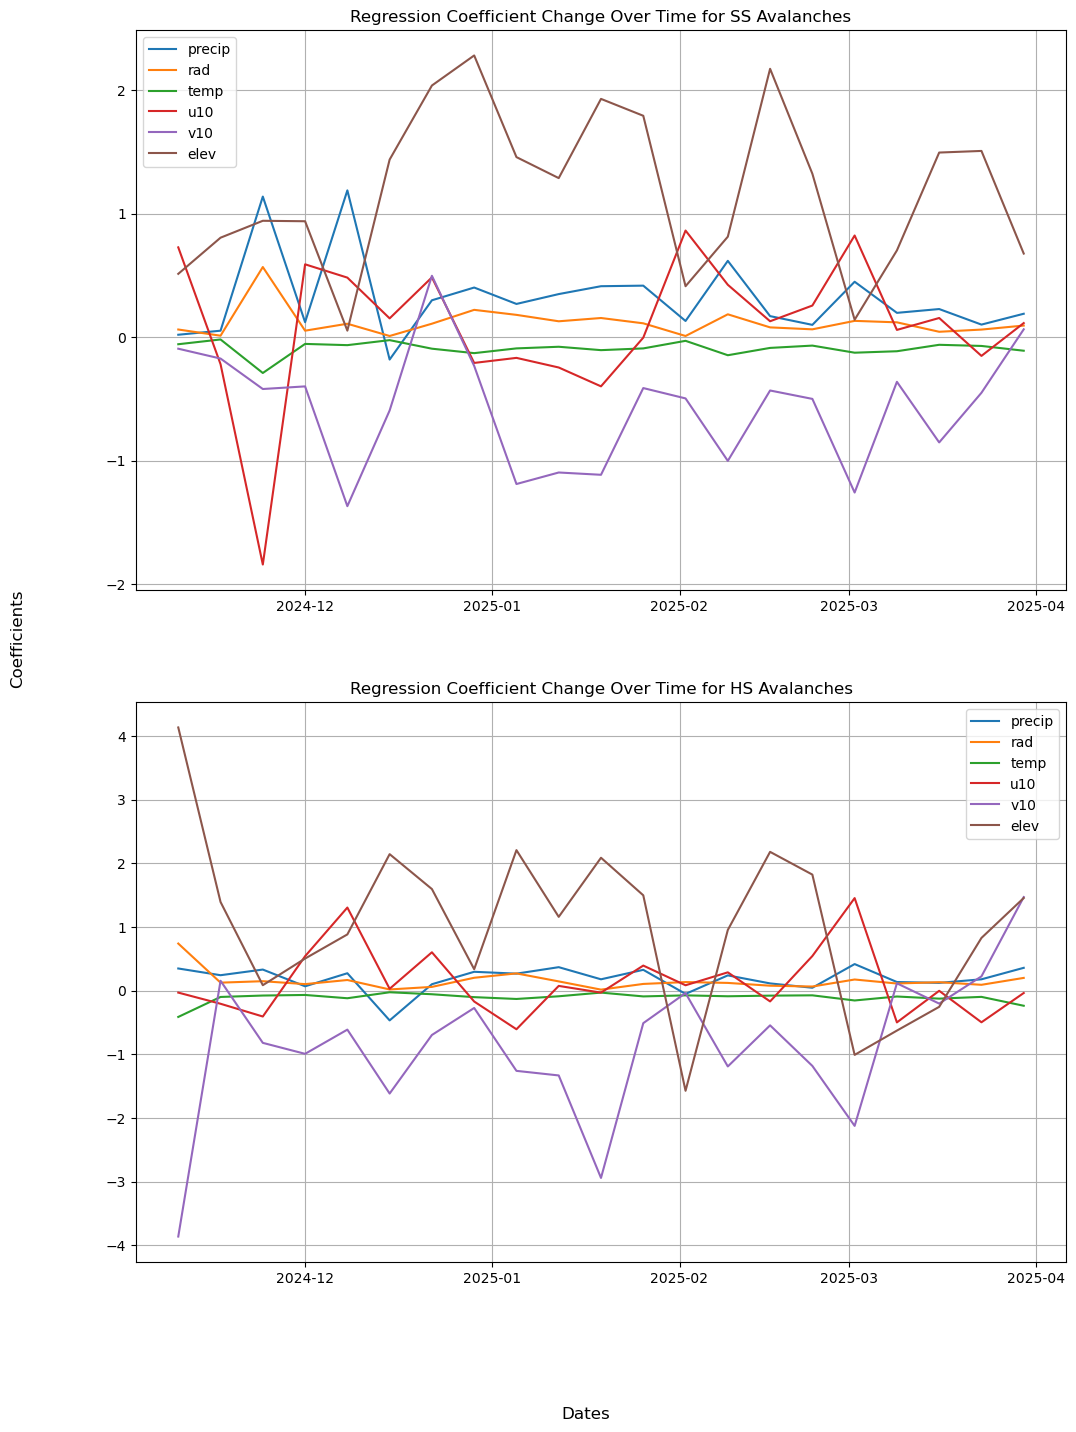

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
fig.supxlabel('Dates')
fig.supylabel('Coefficients')
col_names = []
for week, group in weekly_groups:
    col_names.append(week)

for axis, aval_type in zip([ax1, ax2], [' SS', ' HS']):
    params = []
    for i in range(len(weekly_groups)):
        avalanche_count = []
        precip_by_cell = []
        rad_by_cell = []
        temp_by_cell = []
        u10_by_cell = []
        v10_by_cell = []
        for week, group in weekly_groups:
            if week == week_timestamp[i]:
                group = group[group["Type"] == aval_type]
                # print(group)
                float_lon = [float(x) for x in group['Longitude']]
                float_lat = [float(x) for x in group['latitude']] 
                for lon, lat in avalanche_cells:
                    count = len(group[((float_lon <= lon_edges[lon]) & (float_lon >= lon_edges[lon+1])) &
                                        ((float_lat >= lat_edges[lat]) & (float_lat <= lat_edges[lat+1]))])
                    avalanche_count.append(count)
                    precip_by_cell.append(weekly_tp.sel(valid_time=week_label[i], latitude=lat_edges[lat], longitude=lon_edges[lon], method='nearest').item())
                    rad_by_cell.append(weekly_ssrd.sel(valid_time=week_label[i], latitude=lat_edges[lat], longitude=lon_edges[lon], method='nearest').item())
                    temp_by_cell.append(weekly_temp.sel(valid_time=week_label[i], latitude=lat_edges[lat], longitude=lon_edges[lon], method='nearest').item())
                    u10_by_cell.append(weekly_u10.sel(valid_time=week_label[i], latitude=lat_edges[lat], longitude=lon_edges[lon], method='nearest').item())
                    v10_by_cell.append(weekly_v10.sel(valid_time=week_label[i], latitude=lat_edges[lat], longitude=lon_edges[lon], method='nearest').item())

        df = pd.DataFrame({'avalanche_count': avalanche_count, 'precip': precip_by_cell, 'rad': rad_by_cell, 'temp': temp_by_cell, 'u10': u10_by_cell, 'v10': v10_by_cell, 'elev': elev_by_cell})
        df['rad'] /= 3600 
        df['elev'] /= 1000  

        df['avalanche_occurrence'] = (df['avalanche_count'] >= 1).astype(int)

        logistic_model = sm.Logit(df['avalanche_occurrence'], df[['precip', 'rad', 'temp', 'u10', 'v10', 'elev']]).fit()
        print(aval_type + " Week " + str(i) + ":")
        print(logistic_model.summary())
        params.append(logistic_model.params)

    df_2 = pd.concat(params, axis = 1)
    df_2.columns = col_names
    df_2 = df_2.T
    df_2["precip"] = df_2["precip"] / 1000
    for row_name in ['precip', 'rad', 'temp', 'u10', 'v10', 'elev']:
        axis.plot(df_2.index, df_2[row_name], label=row_name)

    axis.set_title('Regression Coefficient Change Over Time for' + aval_type + ' Avalanches')
    axis.legend()
    axis.grid(True)


In [213]:

col_names = []
for week, group in weekly_groups:
    col_names.append(week)
df_2.columns = col_names
df_2 = df_2.T
df_2["precip"] = df_2["precip"] / 1000
# for i in range(21):
#     col_names.append("week " + str(i))
# df_2.columns = col_names
# df_2

In [214]:
df_2

,precip,rad,temp,u10,v10,elev
2024-11-10,0.018820,0.061172,-0.057988,0.726379,-0.094250,0.512042
2024-11-17,0.051539,0.011019,-0.019374,-0.219625,-0.174055,0.804772
2024-11-24,1.137650,0.567087,-0.290910,-1.842137,-0.420605,0.941667
2024-12-01,0.120572,0.051679,-0.055444,0.589114,-0.399446,0.937882
2024-12-08,1.187942,0.107911,-0.065439,0.481419,-1.369405,0.052098
2024-12-15,-0.182028,0.008744,-0.024912,0.151410,-0.594514,1.437260
2024-12-22,0.297905,0.108196,-0.094147,0.483428,0.496333,2.037044
2024-12-29,0.401091,0.220387,-0.130182,-0.209454,-0.233614,2.280502
2025-01-05,0.268246,0.179783,-0.091698,-0.168511,-1.190026,1.457353
2025-01-12,0.348088,0.127803,-0.078512,-0.246439,-1.096738,1.287282


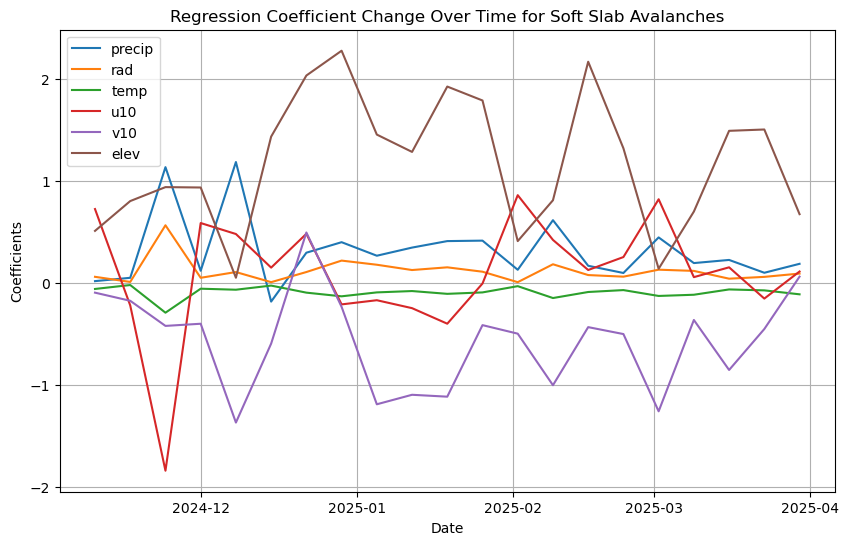

In [217]:
plt.figure(figsize=(10, 6))
for row_name in ['precip', 'rad', 'temp', 'u10', 'v10', 'elev']:
    #print(row_name)
    plt.plot(df_2.index, df_2[row_name], label=row_name)

plt.xlabel('Date')
plt.ylabel('Coefficients')
plt.title('Regression Coefficient Change Over Time for Soft Slab Avalanches')
plt.legend()
plt.grid(True)
plt.show()